# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project
### Louis Pienaar - June 2017
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

### Start with the Import statements

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import glob
import cv2
import numpy as np
from skimage.feature import hog
import time
from moviepy.editor import VideoFileClip
import pickle
import matplotlib.image as mpimg
from IPython.display import HTML
import matplotlib.pyplot as plt

%matplotlib inline


### Load the training images

In [2]:
car_i = glob.glob('Data/vehicles/**/*.png')
noncar_i = glob.glob('Data/non-vehicles/**/*.png')
print(len(car_i), len(noncar_i))

8792 8968


### Explore a random sample of the images

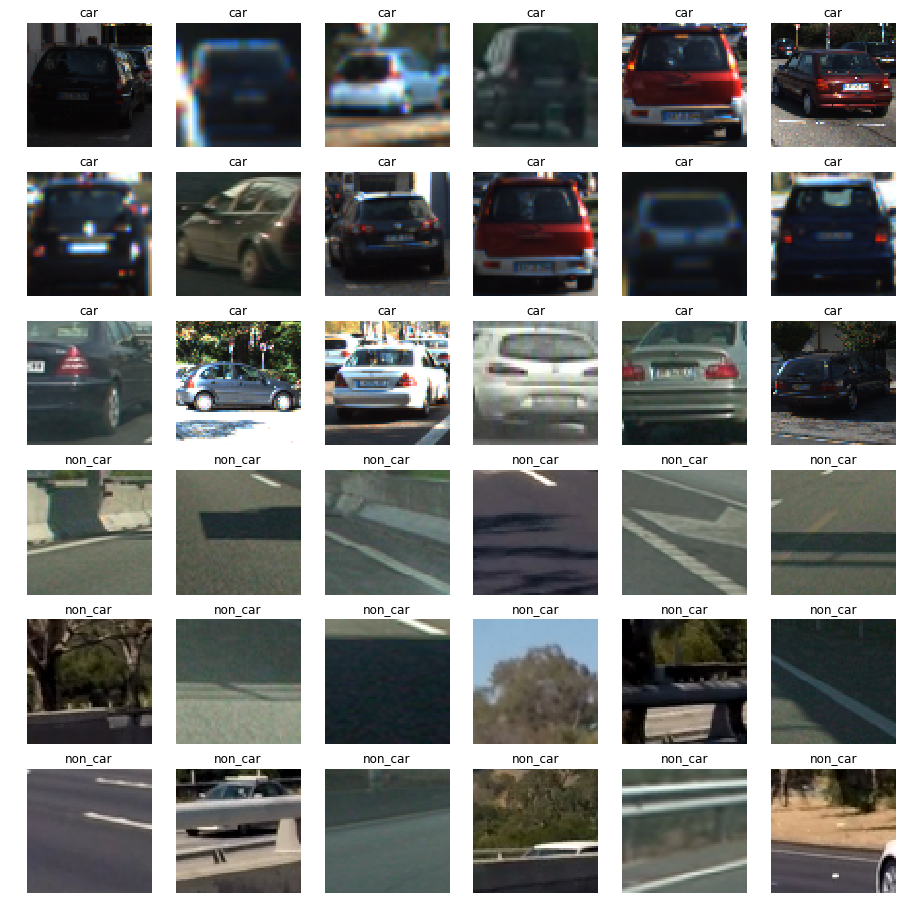

In [3]:
fig, axs = plt.subplots(6,6, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(18):
    img = cv2.imread(car_i[np.random.randint(0,len(car_i))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=12)
    axs[i].imshow(img)
    
for i in np.arange(18,36):
    img = cv2.imread(noncar_i[np.random.randint(0,len(noncar_i))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non_car', fontsize=12)
    axs[i].imshow(img)

### Extract and visualise the HOG features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('.')

.


...


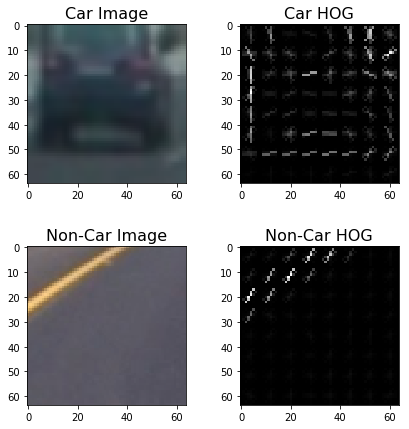

In [5]:
car_img = mpimg.imread(car_i[15])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_i[15])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

### Extract HOG features as a feature set for all the images

The feature extraction functions can be found in the FeatureExtraction.py file

In [6]:
from FeatureExtraction import *

color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=11
pix_per_cell=16
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True

car_features = extract_features(car_i, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(noncar_i, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### Scale and split the data

In [7]:

from sklearn.preprocessing import StandardScaler

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [8]:
# Split up data into randomized training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify =y)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 4356


### Train a SVC model to classify between Car and Non-Car

In [9]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Accuracy = ', round(svc.score(X_test, y_test), 4))


9.63 Seconds to train SVC...
Accuracy =  0.989


### Function to draw the boxes

In [43]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print(' ')

### Visualise the search grid

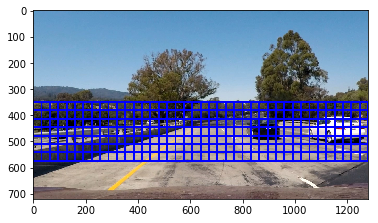

In [44]:
from FeatureExtraction import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
%matplotlib inline

img = mpimg.imread('test_images/test1.jpg')


ystart = 350
ystop = 600
scale = 1

test = []
   
out_img_box = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,True,True)
test.append(out_img_box)
flattest = [item for sublist in test for item in sublist]
out_img = draw_boxes(img,flattest)
plt.imshow(out_img)

print(" ")

### Save the SVC model and the parameters in a pickle

In [12]:
import pickle

data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('model-params.pk', 'wb') as pFile:
    pickle.dump(data, pFile)

### Use scaling to adjust the search grid for near and far cars

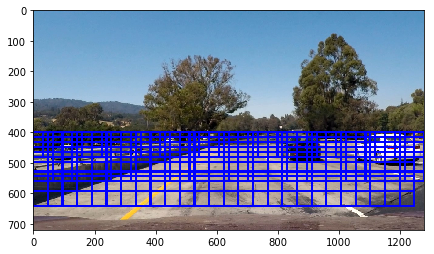

In [45]:
import FeatureExtraction
from FeatureExtraction import *
import importlib

from FeatureExtraction import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
%matplotlib inline

img = mpimg.imread('test_images/test1.jpg')


ystart = 350
ystop = 600
scale = 1

test = []
   
out_img_box = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,True,False)
test.append(out_img_box)

#img = mpimg.imread('test_images/test1.jpg')


test_img = mpimg.imread('test_images/test1.jpg')

rect = []
testbox = []

color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=11
pix_per_cell=16
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True


ystart = 400
ystop = 464
scale = 1.0
out_img_box = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block,
                        hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=True)
rect.append(out_img_box)

ystart = 416
ystop = 480
scale = 1.0
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=True))
ystart = 400
ystop = 496
scale = 1.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=True))

ystart = 400
ystop = 656
scale = 1.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=True))

ystart = 400
ystop = 528
scale = 2.0
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=True))
ystart = 432
ystop = 560
scale = 2.0
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=True))
ystart = 400
ystop = 596
scale = 3.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=True))

#print(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                           # hog_channel, spatial_size, hist_bins,True,True))


rectangles = [item for sublist in rect for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(7,7))
plt.imshow(test_img_rects)

print(" ")

### Results of the search grid : Boxes that SVC predicted as Car

Notice the one false positive on the left hand side

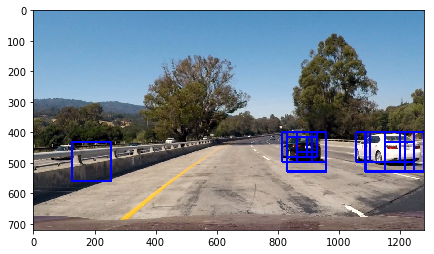

In [28]:
import FeatureExtraction
from FeatureExtraction import *
import importlib

from FeatureExtraction import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
%matplotlib inline

img = mpimg.imread('test_images/test1.jpg')


ystart = 350
ystop = 600
scale = 1

test = []
   
out_img_box = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins,True,False)
test.append(out_img_box)

#img = mpimg.imread('test_images/test1.jpg')


test_img = mpimg.imread('test_images/test1.jpg')

rect = []
testbox = []

color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=11
pix_per_cell=16
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True


ystart = 400
ystop = 464
scale = 1.0
out_img_box = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block,
                        hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False)
rect.append(out_img_box)

ystart = 416
ystop = 480
scale = 1.0
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
ystart = 400
ystop = 496
scale = 1.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
ystart = 432
ystop = 528
scale = 1.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))

ystart = 400
ystop = 656
scale = 1.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))

ystart = 400
ystop = 528
scale = 2.0
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
ystart = 432
ystop = 560
scale = 2.0
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
ystart = 400
ystop = 596
scale = 3.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
ystart = 464
ystop = 660
scale = 3.5
rect.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))

#print(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                           # hog_channel, spatial_size, hist_bins,True,True))


rectangles = [item for sublist in rect for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(7,7))
plt.imshow(test_img_rects)


### Using a heatmap and threshold to deal with false positives

False positives often only have one box, whereas true positives have more than one overlapping box

In [31]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print(' ')

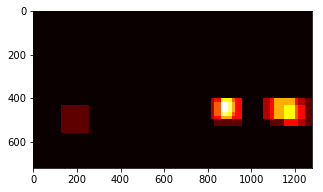

In [32]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(5,5))
plt.imshow(heatmap_img, cmap='hot')

print(' ')

In [33]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print(' ')

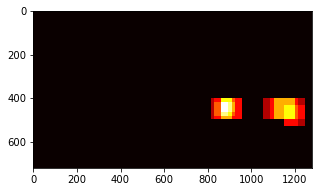

In [34]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(5,5))
plt.imshow(heatmap_img, cmap='hot')

print(' ')

2 cars found


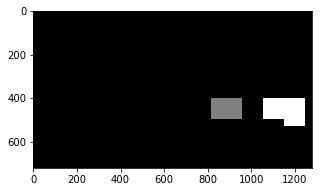

In [35]:
labels = label(heatmap_img)
plt.figure(figsize=(5,5))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

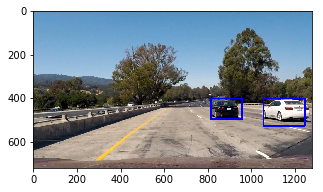

In [36]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(5,5))
plt.imshow(draw_img)
print(' ')

### Initial pipeline 

In [37]:
def process_frame(img):

    rectangles = []
    
    color_space='YCrCb'
    spatial_size=(32, 32)
    hist_bins=32
    orient=11
    pix_per_cell=16
    cell_per_block=2
    hog_channel='ALL'
    spatial_feat=True
    hist_feat=True
    hog_feat=True

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,rect_return=True,show_all_rectangles=False))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print(' ')

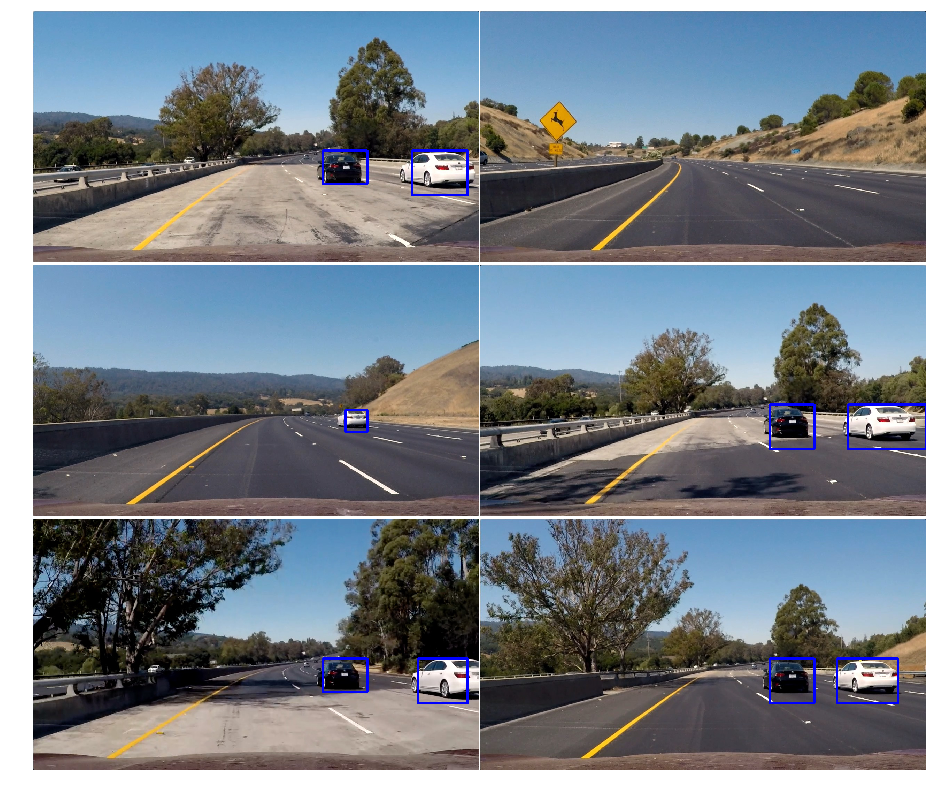

In [38]:
test_images = glob.glob('test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

### Apply the pipeline on the test video

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:17<00:00,  2.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 17.9 s


### Converted the pipeline functions into a class

To help deal with false positives and to bring some continuity and smoothing to the vehicle detection video, it usefull to use a class to keep record of past images and results.

Below is the test results of an image using the class and then applying the class to the project video.

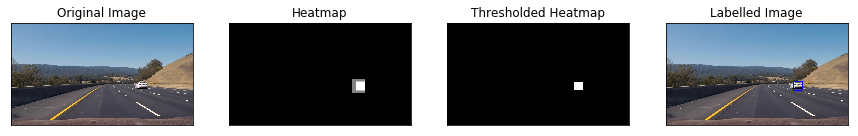

In [41]:
import VehicleDetection
importlib.reload(VehicleDetection)
from VehicleDetection import VehicleDetector
import importlib

vehicleDetector = VehicleDetector('model-params.pk')
vehicleDetector.ystart_ystop_scale =  [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5), (400, 464, 1.0), (416, 480, 1), (400, 496, 1.5), (432, 532, 1.5), (400, 528, 2.0), (430, 560, 2.0), (400, 596, 3.5), (464, 660, 3.5)]
vehicleDetector.threshold = 3


img = mpimg.imread('test_images/test3.jpg')
out = vehicleDetector.find_cars(img,False,False)


plt.figure(figsize=(15,40))

## Input Image
plt.subplot(141)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])


## Heatmap
plt.subplot(142)
heatmap = vehicleDetector.heat_images[0]
plt.imshow(heatmap, cmap='gray')
plt.title('Heatmap')
plt.xticks([])
plt.yticks([])

## Thresholded Heatmap
plt.subplot(143)
t_heatmap = vehicleDetector.heatmap
plt.imshow(t_heatmap, cmap='gray')
plt.title('Thresholded Heatmap')
plt.xticks([])
plt.yticks([])



## Label Detection
plt.subplot(144)
from scipy.ndimage.measurements import label
labels = label(t_heatmap)
labelled_image = np.copy(img)
VehicleDetector.draw_labeled_bboxes(labelled_image, labels)
plt.imshow(out)
plt.title('Labelled Image')
plt.xticks([])
plt.yticks([])

print(" ")

In [ ]:
import VehicleDetection
import importlib
importlib.reload(VehicleDetection)
from VehicleDetection import VehicleDetector


vehicleDetector = VehicleDetector('model-params.pk')
vehicleDetector.ystart_ystop_scale =  [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5), (400, 464, 1.0), (416, 480, 1), (400, 496, 1.5), (432, 532, 1.5), (400, 528, 2.0), (430, 560, 2.0), (400, 596, 3.5), (464, 660, 3.5)]
vehicleDetector.threshold = 6

from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_out_file2 = 'project_video_output_adv_lane_out.mp4'
clip_test2 = VideoFileClip('project_video_output_adv_lane.mp4')
clip_test_out2 = clip_test2.fl_image(vehicleDetector.find_cars)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

[MoviePy] >>>> Building video project_video_output_adv_lane_out.mp4
[MoviePy] Writing video project_video_output_adv_lane_out.mp4


  0%|▍                                                                                | 6/1261 [00:03<11:43,  1.78it/s]